In [3]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import sys
import copy
from tqdm.notebook import tqdm
from numba import jit
from scipy import stats
import networkx as nx
import re


import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
plt.style.use('seaborn-deep')
plt.rcParams["text.usetex"] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amssymb,amsmath}'

plt.rcParams["figure.figsize"] = 11.7, 8.3
plt.rcParams["figure.dpi"] = 75

plt.rcParams["font.size"] = 28
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Fira Sans", 'PT Sans', 'Open Sans', 'Roboto', 'DejaVu Sans', 'Liberation Sans', 'sans-serif']

plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.fontsize"] = "small"

plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams["lines.markersize"] = 14
plt.rcParams["lines.markeredgewidth"] = 2

plt.rcParams["xtick.major.size"] = 8
plt.rcParams["ytick.major.size"] = 8

In [19]:
all_params_without_i = ['with_features', 'lp_test_size', 'Beta_s', 'gamma_s', 'Ns_obs', 'kmean_s',
                        'gamma_n', 'kmean_n', 'gamma_f', 'N_f', 'Beta_bi', 'nu']

df = pd.read_csv("../results/results_link_prediction.csv")
df.head()

,model,with_features,lp_test_size,Beta_s,gamma_s,Ns_obs,kmean_s,gamma_n,kmean_n,gamma_f,N_f,Beta_bi,nu,i,AUC,ap,prc
0,MLP_Euclidean,1.0,0.1,1.1,2.1,5000.0,30.0,3.5,3.0,3.5,2000.0,3.0,0.0,7.0,81.257128,77.673438,62.503987
1,MLP_Euclidean,1.0,0.1,1.1,2.1,5000.0,3.0,2.1,3.0,3.5,2000.0,3.0,0.0,5.0,66.804688,61.005722,54.869684
2,MLP_Euclidean,1.0,0.1,1.1,2.1,5000.0,3.0,3.5,3.0,3.5,2000.0,3.0,0.0,3.0,81.888587,77.694305,62.506667
3,MLP_Euclidean,1.0,0.1,3.0,2.1,5000.0,30.0,2.1,3.0,2.1,2000.0,3.0,0.0,7.0,76.247740,67.894697,59.608782
4,MLP_Euclidean,1.0,0.1,1.1,2.1,5000.0,30.0,3.5,30.0,2.1,2000.0,1.1,0.0,0.0,73.130703,70.902864,56.241521


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MLP_Euclidean vs. HNN_PoincareBall: Mann-Whitney-Wilcoxon test two-sided, P_val:9.726e-119 U_stat=3.860e+05
HNN_PoincareBall vs. GCN_Euclidean: Mann-Whitney-Wilcoxon test two-sided, P_val:1.667e-23 U_stat=1.006e+06
GCN_Euclidean vs. GAT_Euclidean: Mann-Whitney-Wilcoxon test two-sided, P_val:8.012e-13 U_stat=6.853e+05
GAT_Euclidean vs. HGCN_PoincareBall: Mann-Whitney-Wilcoxon test two-sided, P_val:6.635e-65 U_stat=5.006e+05
GCN_Euclidean vs. HGCN_PoincareBall: Mann-Whitney-Wilcoxon test two-sided, P_val:2.711e-101 U_stat=4.192e+05
HNN_PoincareBall vs. GAT_Euclidean: Mann-Whitney-Wilcoxon test two-sided, P_val:2.900e-07 U_stat=9.151e+05
HNN_PoincareBall vs. HGCN_PoincareBall: Mann-Whitney-Wilcoxon test two-sided, P_val:6.514e-24 U_stat=6.301e+05


(<Axes: ylabel='AUC'>,
  <statannotations.Annotation.Annotation at 0x7fc50e7e51e0>])

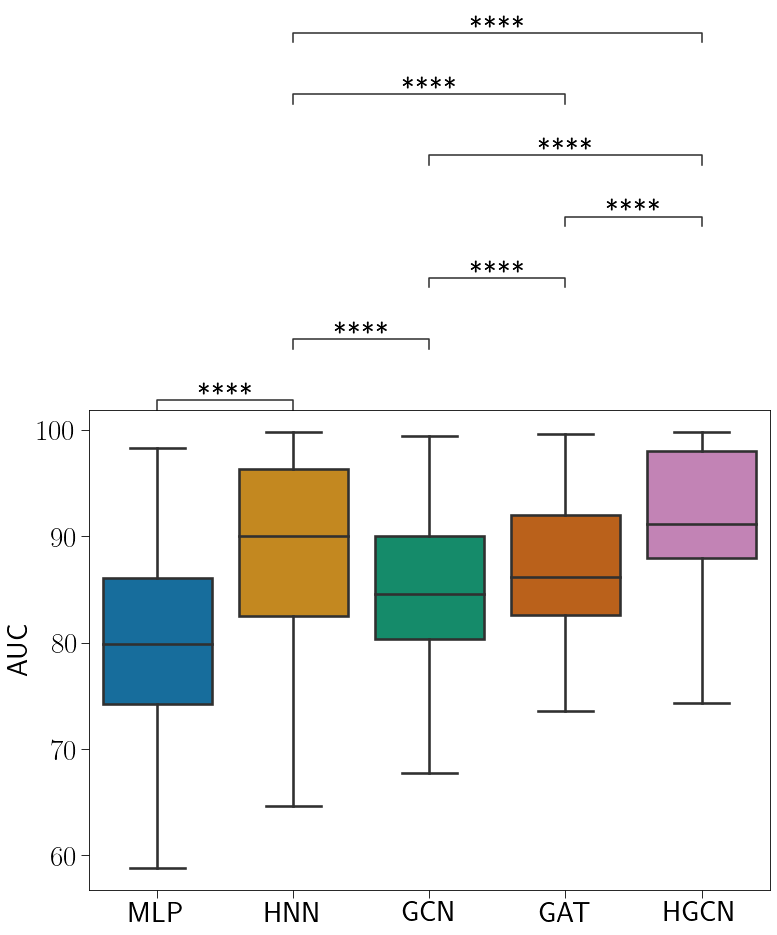

In [20]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots()

my_order = ['MLP_Euclidean', 'HNN_PoincareBall', 'GCN_Euclidean', 'GAT_Euclidean', 'HGCN_PoincareBall']

# Select pairs of models to compute the Mann-Whitney test
my_pairs = [
    (my_order[0], my_order[1]),
    (my_order[1], my_order[2]),
    (my_order[2], my_order[3]),
    (my_order[3], my_order[4]),
    (my_order[2], my_order[4]),
    (my_order[1], my_order[3]),
    (my_order[1], my_order[4]),
]

sns.boxplot(data=df, x='model', y='AUC', order=my_order, palette="colorblind")
ax.set_ylabel('AUC')
ax.set_xlabel('')
ax.set_xticks([0, 1, 2, 3, 4], ['MLP', 'HNN', 'GCN', 'GAT', 'HGCN'])

annotator = Annotator(ax, my_pairs, data=df, x='model', y='AUC', order=my_order, verbose=False)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', 
                    text_offset=0, line_offset_to_group=0.01, verbose=2, line_height=0.02)
#loc='inside'
annotator.apply_test().annotate(line_offset_to_group=0.001, line_offset=0.001)